<a href="https://colab.research.google.com/github/emiliomercuri/ciencia_dados/blob/main/aulas/2023_12_06_Aula_14_PyTorch_(Custom_Datasets)_(aula).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 14 - Criando o nosso próprio Conjunto de Dados de Imagens para identificação de padrões usando Redes Neurais Convolucionais

## Importando PyTorch e configurando o código independente do dispositivo

In [1]:
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Baixar os dados

In [3]:
import requests
import zipfile
from pathlib import Path

# Configurar o caminho "path" para a pasta dos dados
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Se a pasta não existir, faça o download e prepare a pasta...
if image_path.is_dir():
  print(f"a pasta {image_path} já existe... pulando o download")
else:
  print(f"a pasta {image_path} não existe, criando-a...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/emiliomercuri/ciencia_dados/raw/main/dados/pizza_steak_sushi.zip")
  print(f"Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Deszipar pizza, steak and sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

a pasta data/pizza_steak_sushi não existe, criando-a...
Unzipping pizza, steak and sushi data...


## 2. Vamos nos familiarizar com os dados (preparar os dados e explorá-los).

In [8]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [9]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [10]:
# Configurar os caminhos de teste e treinamento
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizando algumas imagens aleatórias

Random image path: data/pizza_steak_sushi/train/sushi/1552504.jpg
Image class: sushi
Image height: 512
Image width: 384


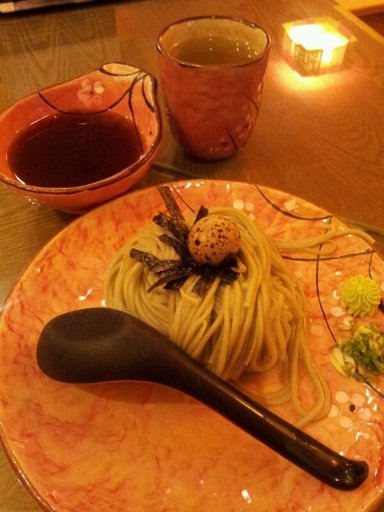

In [16]:
import random
from PIL import Image

#random.seed(42)

# 1. Obter todos os caminhos das imagens
image_path_list = list(image_path.glob("*/*/*.jpg"))
#image_path_list

# 2. Selecionar uma image randômica
random_image_path = random.choice(image_path_list)
#print(random_image_path)

# 3. Obter a classe da imagem com base no caminho (subpasta)
image_class = random_image_path.parent.stem
#print(image_class)

# 4. Abrir a imagem
img = Image.open(random_image_path)

# 5. Imprimir metadados da imagem
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

### Visualizar usando matplolib

In [18]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Transformar a imagem em um array
img_as_array = np.asarray(img)

print(type(img_as_array), img_as_array.shape)

<class 'numpy.ndarray'> (512, 384, 3)


In [22]:
#img_as_array

(-0.5, 383.5, 511.5, -0.5)

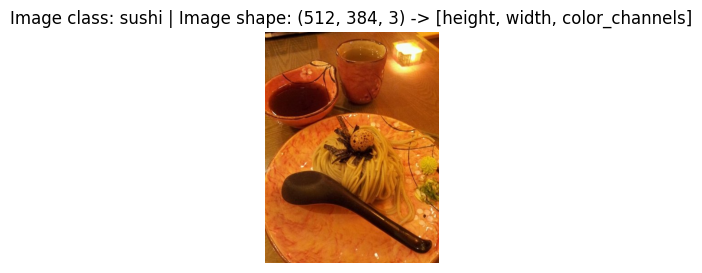

In [23]:
# Plot usando matplotlib
plt.figure(figsize=(5,3))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

# 3. Transformar os dados


In [24]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [26]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64X64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [27]:
data_transform(img)

tensor([[[0.6275, 0.6667, 0.5294,  ..., 0.8863, 0.8471, 0.8039],
         [0.5059, 0.4706, 0.3333,  ..., 0.5843, 0.5373, 0.4902],
         [0.2941, 0.3059, 0.3216,  ..., 0.4706, 0.4353, 0.4196],
         ...,
         [0.6745, 0.6706, 0.6549,  ..., 0.8510, 0.8824, 0.8510],
         [0.6667, 0.6549, 0.6392,  ..., 0.9020, 0.8157, 0.6392],
         [0.6824, 0.6667, 0.6471,  ..., 0.7922, 0.6078, 0.4549]],

        [[0.4235, 0.4549, 0.3294,  ..., 0.5176, 0.4706, 0.4118],
         [0.3333, 0.3020, 0.1961,  ..., 0.2235, 0.1922, 0.1686],
         [0.1373, 0.1451, 0.1529,  ..., 0.1765, 0.1451, 0.1373],
         ...,
         [0.4078, 0.4078, 0.3882,  ..., 0.4157, 0.4902, 0.4745],
         [0.4078, 0.3961, 0.3765,  ..., 0.5137, 0.4353, 0.2745],
         [0.4235, 0.4078, 0.3882,  ..., 0.4314, 0.2510, 0.1608]],

        [[0.2196, 0.2392, 0.1804,  ..., 0.0627, 0.0471, 0.0471],
         [0.1647, 0.1451, 0.0980,  ..., 0.0196, 0.0196, 0.0235],
         [0.0275, 0.0314, 0.0431,  ..., 0.0196, 0.0157, 0.

In [28]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [29]:
data_transform(img).dtype

torch.float32

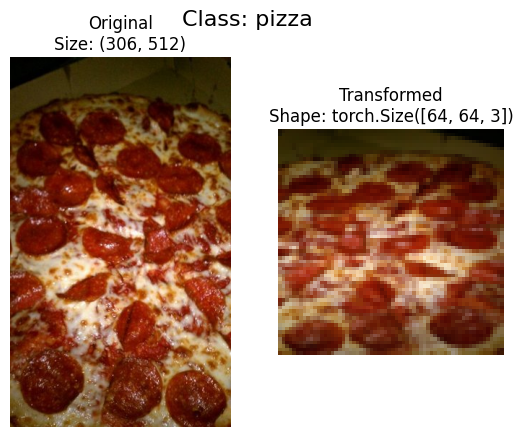

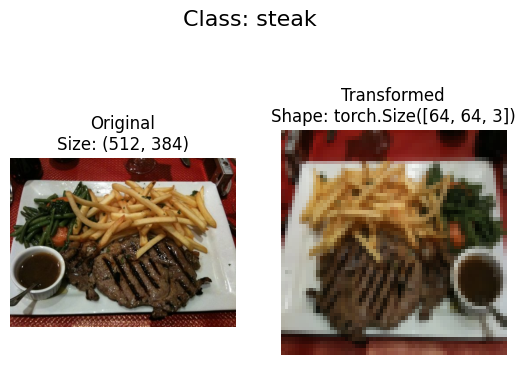

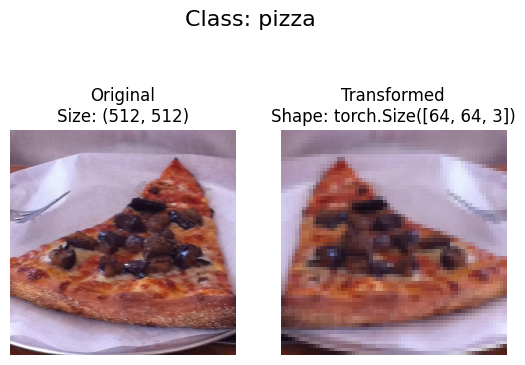

In [33]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Select random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # note we will need to change chape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## Importando as imagens em datasets do torchvision

In [35]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [36]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [37]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
len(train_data), len(test_data)

(225, 75)

## Passar de Dataset para DataLoader

Um `DataLoader` vai nos auxiliar a tranformar o Dataset em um item iterável e podemos customizar em `batches` (ou lotes) de imagens.

In [40]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size= BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size= BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b6b6a0fe0e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b6b4d6ef340>)

## 6. Other forms of transforms (data augmentation)

We've seen a couple of transforms on our data already but there's plenty more.

You can see them all in the [`torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).

The purpose of tranforms is to alter your images in some way.

That may be turning your images into a tensor (as we've seen before).

Or cropping it or randomly erasing a portion or randomly rotating them.

Doing this kinds of transforms is often referred to as **data augmentation**.

**Data augmentation** is the process of altering your data in such a way that you *artificially* increase the diversity of your training set.

Training a model on this *artificially* altered dataset hopefully results in a model that is capable of better *generalization* (the patterns it learns are more robust to future unseen examples).

You can see many different examples of data augmentation performed on images using `torchvision.transforms` in PyTorch's [Illustration of Transforms example](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#illustration-of-transforms).

But let's try one out ourselves.

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) and [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)) generally perform better than hand-picked transforms.

The idea behind [TrivialAugment](https://arxiv.org/abs/2103.10158) is... well, trivial.

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

The PyTorch team even [used TrivialAugment it to train their latest state-of-the-art vision models](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements).


*TrivialAugment was one of the ingredients used in a recent state of the art training upgrade to various PyTorch vision models.*

How about we test it out on some of our own images?

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`.

It defines how much of a range an intensity value will be picked to apply a certain transform, `0` being no range and `31` being maximum range (highest chance for highest intensity).

We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.